# A Simple Example of Solving PDE with DL

In [4]:
import time

import torch
from tqdm import trange
from torch import nn, autograd, optim

%matplotlib notebook 
import matplotlib.pyplot as plt

from nets import *
from graphics import *

ModuleNotFoundError: No module named '__main__.nets'; '__main__' is not a package

In [2]:
# Exact solution of the problem {du/dt + a du/dx = 0, u(0, x) = gauss(x), u(t, 0) = 0}
def dome(x, t=0, a=.5, alpha=200):
    if isinstance(t, torch.Tensor):
        t = t[:, None]
    res = torch.exp(-alpha*((x-.25) - a*t)**2)
    out = torch.zeros_like(res)
    out[x - a*t > 0] = res[x - a*t > 0]
    
    return out

In [3]:
class PDE2D(nn.Module):
    """
    Base class
    ----------
    Args:
    -----
    l                 length of calculation area along x axis
                      (starting from 0)
    T                 length of calculation area along t axis
                      (starting from 0)

                      Thus, (0, l) x (0, T) is the training domain
    """
    def __init__(self, l=1., T=2., device='cpu'):
        super().__init__()
        self.l = l
        self.T = T
        self.device = device
    
    def sampleBatch(self, N=5120, M=4096, K=4096):
        """
        N - number of points to sample in the domain (x, t)
        M - __..__..__..__..__ to sample on the x axis
        """
        x = torch.zeros(M, 2, device=self.device)
        x[:, 1] = self.l * torch.rand(M, device=self.device)
        
        t0 = torch.zeros(K, 2, device=self.device)
        t0[:, 0] = self.T * torch.rand(K, device=self.device)

        tx = torch.rand(N, 2, device=self.device)
        tx[:, 0].mul_(self.T)
        tx[:, 1].mul_(self.l)

        return tx, x, t0
    
    def _D(self, y, x):
        grad = autograd.grad(
            outputs=y, inputs=x,
            grad_outputs=torch.ones_like(y),
            create_graph=True, allow_unused=True)[0]
            
        return grad

In [4]:
class FisherPDE(PDE2D):
    """
    u_t + a u_xx = r u(1-u)
    ----------
    Args:
    -----
    a             diffusion coefficient
    r             some other coefficient
    """
    def __init__(self, a=.5, r=.1, l=1., T=2., device='cpu'):
        super().__init__(l, T, device)
        self.a = a
        self.r = r
        
    def conditionLoss(self, x_border, y_border):
        pass

    def computeLoss(self, x_domain, x_border, net, delta=.01):
        t, x = torch.unbind(x_domain, 1)
        
        D1 = delta * torch.randn_like(x)
        D2 = delta * torch.randn_like(x)
        
        y0 = net(x_domain)
        
        #du_t, u_x = self._D(y0, x_domain)
        du_t = self._D(y0, t)
        du_x0 = self._D(y0, x)
        
        y1_1p = net(torch.stack(t, x+D1))
        y1_1m = net(torch.stack(t, x-D1))
        
        y2_1p = net(torch.stack(t, x+D2))
        y2_1m = net(torch.stack(t, x-D2))
        
        d2u_xx_1p = 1./delta * (self._D(y1_1p) - u_x) * D1
        d2u_xx_1p.requires_grad_(False)
        d2u_xx_2p = 1./delta * (self._D(y2_1p) - u_x) * D2
        
        d2u_xx_1m = 1./delta * (self._D(y1_1p) - u_x) * D1
        d2u_xx_1m.requires_grad_(False)
        d2u_xx_2m = 1./delta * (self._D(y2_1p) - u_x) * D2
        d2u_xx = d2u_xx1p*d2u_xx2p + d2u_xx_1m*d2u_xx_2m 
        
        L = (torch.norm(du_t + self.a*du_xx - self.r*y0(1-y0))
             + self.initialCondLoss(x_border, net(x_border)))
        
        return L

In [5]:
class AdvectionPDE(PDE2D):
    """
    Homogeneous Advection Equation
    -------------------------------------
    du/dt + a du/dx = 0
    u(0, x) = gauss(x)
    -------------------------------------
    Args:
    -----
    a                 wave velocity
    """
    def __init__(self, a=.5, l=1., T=2., device='cpu'):
        super().__init__(l, T, device)
        self.a = a
        self.psi = torch.tensor([0.], device=device)

    def computeLoss(self, tx, x, t, net):
        du_t, du_x = torch.unbind(self._D(net(tx), tx), 1)
        L = (torch.norm(du_t + self.a * du_x)
             + torch.norm(net(x) - dome(x[:, 1], a=self.a))
             + torch.norm(net(t) - self.psi))
            
        return L

In [6]:
def train(net, pde, optimizer, loss_history, batch_sizes=(5120, 4096, 4096)):
    for _ in trange(num_batches, desc='Training'):
        optimizer.zero_grad()
     
        batches = pde.sampleBatch(*batch_sizes)
        batches[0].requires_grad_(True)
     
        loss = pde.computeLoss(*batches, net)
        loss_history.append(loss.item())
        loss.backward()
     
        optimizer.step()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_batches = int(1e4)

pde = AdvectionPDE()
#pde = FisherPDE()

# in fact, 10,000 iterations is more than enough
# to obtain a decent approximation in the training domain

#net = DGM(d=1, M=50, L=3).to(device)
net = DumbLinear('3l', base_width=128).to(device)

n_devices = torch.cuda.device_count()
print(f'You have {n_devices} gpus')
if n_devices > 1:
    net = nn.DataParallel(solver,  np.arange(n_devices))
    
optimizer = optim.Adam(net.parameters())
loss_history = []

You have 0 gpus


In [8]:
try:
    train(net, pde, optimizer, loss_history, (128, 128, 128))
except KeyboardInterrupt:
    pass

Training: 100%|██████████| 10000/10000 [02:39<00:00, 62.51it/s]


<IPython.core.display.Javascript object>


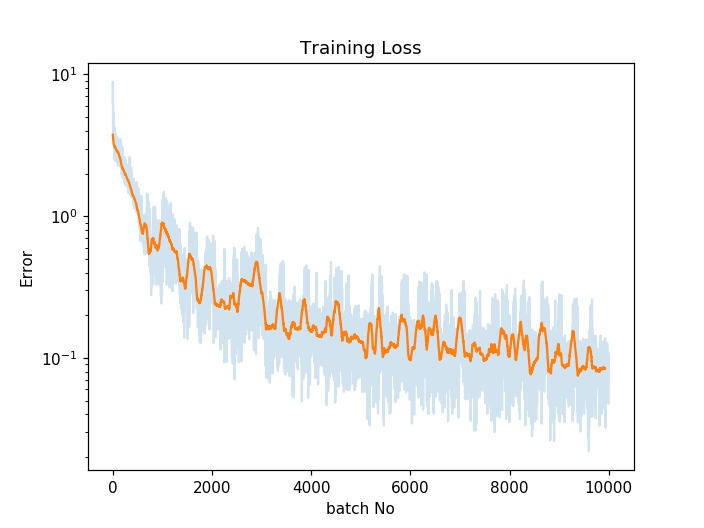

In [9]:
plt.figure()
plt.plot(loss_history, alpha=.2)
plt.plot(running_mean(loss_history))
plt.yscale('log')
plt.title('Training Loss')
plt.ylabel('Error')
plt.xlabel('batch No');
plt.savefig('DGM')

In [11]:
max_error = lambda u_exact, u_approx: torch.norm(u_exact - u_approx, p=float('inf'))
avg_error = lambda u_exact, u_approx: torch.mean((u_exact - u_approx)**2)**.5 

## Initial condition approximation

max error 0.009377062320709229
avg error 0.005115324165672064


<IPython.core.display.Javascript object>


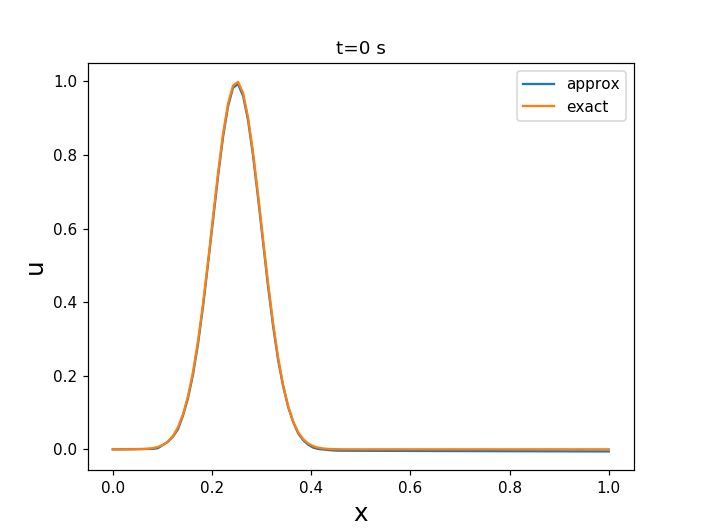

In [12]:
x = torch.linspace(0, 1)
tx = torch.stack((torch.zeros_like(x), x), 1)

y_true = dome(x)
y = net(tx.to(device)).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title('t=0 s')
plt.legend();

## Approximation at time `t`

max error 0.01040726900100708
avg error 0.0037588386330753565


<IPython.core.display.Javascript object>


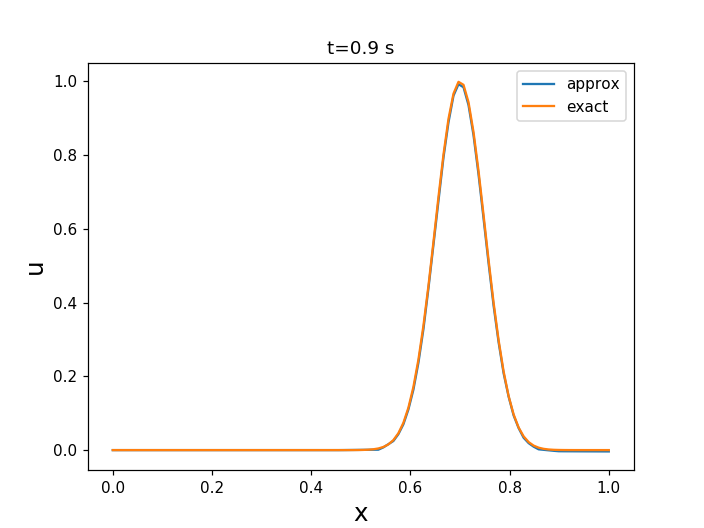

In [13]:
t = .9 
x = torch.linspace(0, 1)
tx = x.new(len(x), 2)
tx[:, 0].fill_(t)
tx[:, 1] = x

y_true = dome(x, t)
y = net(tx.to(device)).detach().cpu()
print('max error', max_error(y_true, y).item())
print('avg error', avg_error(y_true, y).item())
x = x.numpy()

plt.figure()
plt.plot(x, y.numpy(), label='approx')
plt.plot(x, y_true.numpy(), label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f't={t} s')
plt.legend();

## Run cell to start animating
if there is only one graph, re-run the cell

---
As expected, the approximation is fairly good on the training data, and when the model encounters test data the solutions begin to diverge

<IPython.core.display.Javascript object>


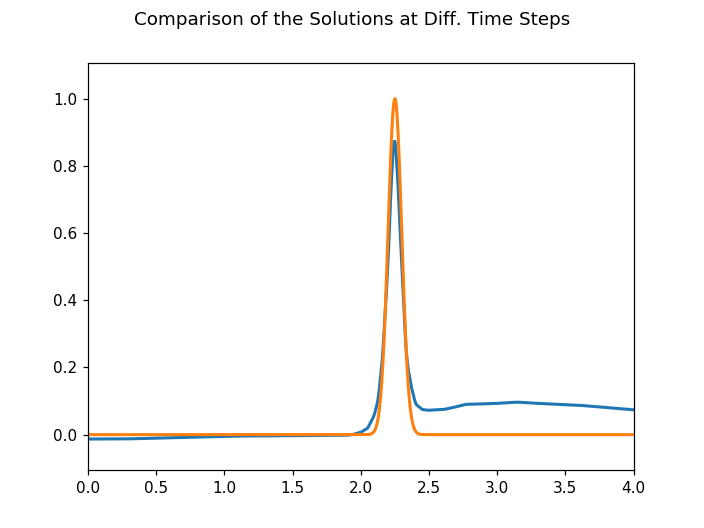

In [15]:
z = torch.linspace(0, 4, 1000)
t = torch.linspace(0, 4)
y = dome(z, t)
true_data = (z.numpy(), y.numpy())

t = t.view(-1, 1)
t = t.expand(-1, len(z))
x = z.view(1, -1)
x = x.expand(len(t), -1)
tx = torch.stack((t, x), -1)
y = net(tx.to(device)).view(len(tx), -1).detach().cpu()
appr_data = (z.numpy(), y.numpy())

fig = plt.figure()
fig.suptitle('Comparison of the Solutions at Diff. Time Steps')
Anime(fig, appr_data)
Anime(fig, true_data);

# test data begins when dome at x = a * T = .5 * 2 = 1

---
## Solving the problem with finite-difference method

$$
\left\{\begin{aligned}
    &u_i^{n+1} = u_i^n + a\Delta t (u_{i-1}^n- u_i^n)\\
    &u_i^0 = \exp(-\alpha(i\Delta h - 0.25)^2)\\
    &u_0^n = 0
\end{aligned}\right.
$$

In [29]:
l = 1
T = 1
u_t0 = torch.tensor([0.])
dx = 1e-3
rdx = 1 / dx
dt = 2e-3
a = .5

x = torch.linspace(0, l, int(l/dx))
u_0x = dome(x, a=a)
u_exact = dome(x, t=T, a=a)

def one_time_step(u):
    return u + torch.cat([u_t0, -a*dt*rdx * (u[1:] - u[:-1])])

In [30]:
u1 = u_0x
for i in range(int(.5 * T / dt)):
    u2 = one_time_step(u1)
    u1 = one_time_step(u2)

<IPython.core.display.Javascript object>


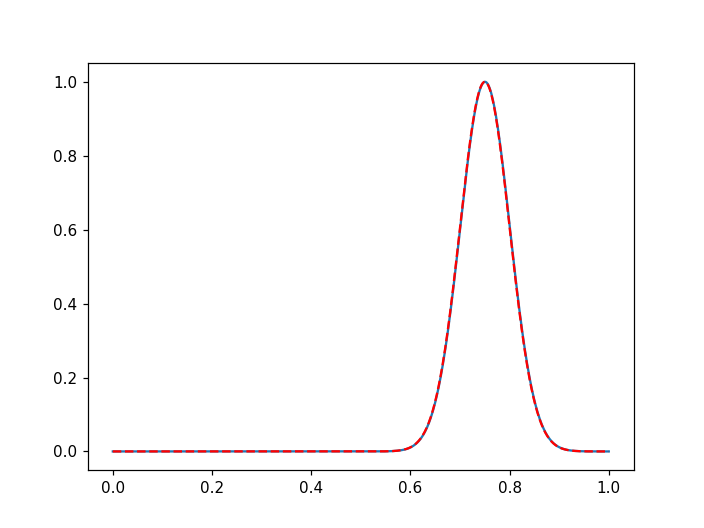

max error 0.0060707926750183105
avg error 0.0021060598082840443


In [31]:
plt.figure()
print('max error', max_error(u_exact, u1).item())
print('avg error', avg_error(u_exact, u1).item())
plt.plot(x.numpy(), u1.numpy())
plt.plot(x.numpy(), u_exact.numpy(), '--r');

## Draft

Testing [PyDEns](https://github.com/analysiscenter/pydens) library

In [2]:
import tensorflow as tf
from pydens import Solver, NumpySampler, add_tokens, cart_prod
add_tokens()

/home/lukoshkin/BuildPacks/miniconda3/envs/SR/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lukoshkin/BuildPacks/miniconda3/envs/SR/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lukoshkin/BuildPacks/miniconda3/envs/SR/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lukoshk

In [ ]:
# Exact solution of the problem {du/dt + a du/dx = 0, u(0, x) = gauss(x)}
# ! forgot to add the condition at t=0, fix this later
def special(x, alpha=200):
    return tf.exp(-200*(x-.25)**2)

In [4]:
pde = {'n_dims': 2,
       'form': lambda u, t, x: D(u, t) + .5 * D(u, x),
       'initial_condition': lambda x: special(x)}

body = {'layout': 'fa fa f',
        'units': [256, 512, 1],
        'activation': [tf.nn.relu, tf.nn.relu, tf.nn.relu]}

config = {'body': body,
          'pde': pde}

us = NumpySampler('uniform', dim=2)
dg = Solver(config)




Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().




In [5]:
%%time
dg.fit(batch_size=100, sampler=us, n_iters=5000)

CPU times: user 3min 17s, sys: 16.6 s, total: 3min 33s
Wall time: 55.3 s


In [3]:
# plot real solution and network approximation
n_el = 100
sol = lambda t: np.exp(-200*((x-.25) - .5*t)**2)
grid = cart_prod(np.linspace(0, 1, n_el), np.linspace(0, 1, n_el))
approxs = dg.solve(grid)
plt.imshow(approxs.reshape(n_el, n_el))
plt.colorbar()
plt.show()

NameError: name 'cart_prod' is not defined

<IPython.core.display.Javascript object>


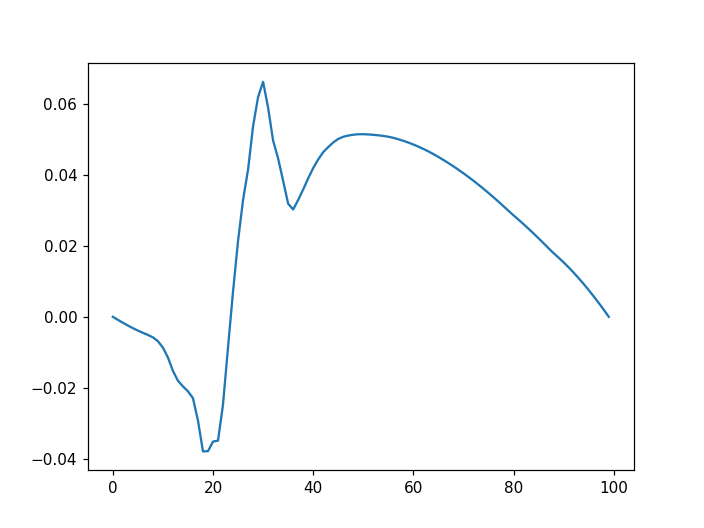

In [9]:
plt.figure()
plt.plot(approxs.reshape(n_el, n_el)[:, 80]);